In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

In [0]:
def inject_noise(signal, noise_level=0.1):
  """
  Corrupt a transmitted signal with noise where the probability of a bit flip is
  specified by the noise level. 

  Parameters
  ----------
    signal: the transmitted signal, a numpy array of 0s and 1s

  Recturns
  --------
    received: the received signal corrupted by the noisy channel
  """
  noise = np.random.binomial(1, noise_level, signal.shape)
  received = (signal+noise) % 2
  return received

def img2bw(img, thresh=200):
  """
  Convert an image to a black and white 0/1 image
  """
  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  t, bw = cv2.threshold(img, thresh, 1, cv2.THRESH_BINARY)
  return bw

def repetition_encode(signal, n=3):
  return signal.repeat(n)

def repetition_code_img(code, bw, n=3):
  code_blocks = code.reshape(-1, n)
  return np.vstack([code_blocks[:, k].reshape(bw.shape) for k in range(n)])

def repetition_decode(received, n=3):
  """
  Majority vote to decode a noisy repetition encoded signal
  """
  received_blocks = received.reshape(-1, n)
  sums = np.sum(received_blocks, axis=1).astype(np.uint8)
  thr, decoded = cv2.threshold(sums, n/2, 1, cv2.THRESH_BINARY)
  return decoded

def hamming_encode(bw):
  """
  Parameters
  ----------
    bw: a black and white image as numpy array or 0s and 1s
  Returns
  -------
    code: a numpy vector of hamming encoded bits
  """
  G = np.array([[1, 0, 0, 0, 1, 0, 1],
                [0, 1, 0, 0, 1, 1, 0],
                [0, 0, 1, 0, 1, 1, 1],
                [0, 0, 0, 1, 0, 1, 1]])
  vec = bw.reshape(-1)
  if len(vec) % 4: # size needs to be divisible by 4, 0 pad
    vec = np.hstack((vec, (0,)*(4 - len(vec) % 4)))
  blocks = vec.reshape(-1, 4)
  code_blocks = (blocks @ G) % 2
  return code_blocks.reshape(-1)
  
def hamming_code_img(code, bw):
  """
  Create an image with original + parity bits, purely for visualization

  Parameters
  ----------
    code: a hamming encoded bit stream representing a black and white image
    bw: the original image

  Returns
  -------
    code_bw: a black and white code image, purely for visualization, due to
      padding of both the original image and the parity bits it may be a
      different size than the code, only returned if bool is True 

  """
  code_blocks = code.reshape(-1, 7)
  bw_img = code_blocks[:, :4].reshape(-1)[:bw.size].reshape(bw.shape)
  bw_parity = code_blocks[:, 4:]
  if bw_parity.size % bw.shape[1]: # pad if necessary
    num_zeroes = bw.shape[1] - bw_parity.size % bw.shape[1]
    bw_parity = np.hstack((bw_parity.reshape(-1), (0,)*num_zeroes))
  code_bw = np.vstack((bw_img, bw_parity.reshape(-1, bw.shape[1])))
  return code_bw

def hamming_decode(noisy_code):
  """
  Parameters
  ----------
    noisy_code: a hamming encoded bit stream that is corrupted by noise

  Returns
  -------
    msg: the decoded message
  """
  H = np.array([[1, 1, 1, 0, 1, 0, 0],
                [0, 1, 1, 1, 0, 1, 0],
                [1, 0, 1, 1, 0, 0, 1]])
  D = np.array([[0, 0, 0, 0, 0, 0, 0],  # 000
                [0, 0, 0, 0, 0, 0, 1],  # 001
                [0, 0, 0, 0, 0, 1, 0],  # 010
                [0, 0, 0, 1, 0, 0, 0],  # 011
                [0, 0, 0, 0, 1, 0, 0],  # 100
                [1, 0, 0, 0, 0, 0, 0],  # 101
                [0, 1, 0, 0, 0, 0, 0],  # 110
                [0, 0, 1, 0, 0, 0, 0]]) # 111
  code_blocks = noisy_code.reshape(7, -1, order='F')
  z = np.sum((H @ code_blocks % 2) * np.array([[4],[2],[1]]), axis=0)
  decoded_blocks = (D[z].T + code_blocks) % 2
  return decoded_blocks[:4, :].reshape(-1, order='F')


## Read and display image

In [4]:
!wget https://imgs.xkcd.com/comics/datacenter_scale.png

--2020-03-02 13:31:53--  https://imgs.xkcd.com/comics/datacenter_scale.png
Resolving imgs.xkcd.com (imgs.xkcd.com)... 151.101.0.67, 151.101.64.67, 151.101.128.67, ...
Connecting to imgs.xkcd.com (imgs.xkcd.com)|151.101.0.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76598 (75K) [image/png]
Saving to: ‘datacenter_scale.png.1’

datacenter_scale.pn 100%[===================>]  74.80K  --.-KB/s    in 0.03s   

2020-03-02 13:31:53 (2.56 MB/s) - ‘datacenter_scale.png.1’ saved [76598/76598]



In [0]:
img = cv2.imread('datacenter_scale.png', cv2.IMREAD_GRAYSCALE)

In [0]:
bw = img2bw(img)

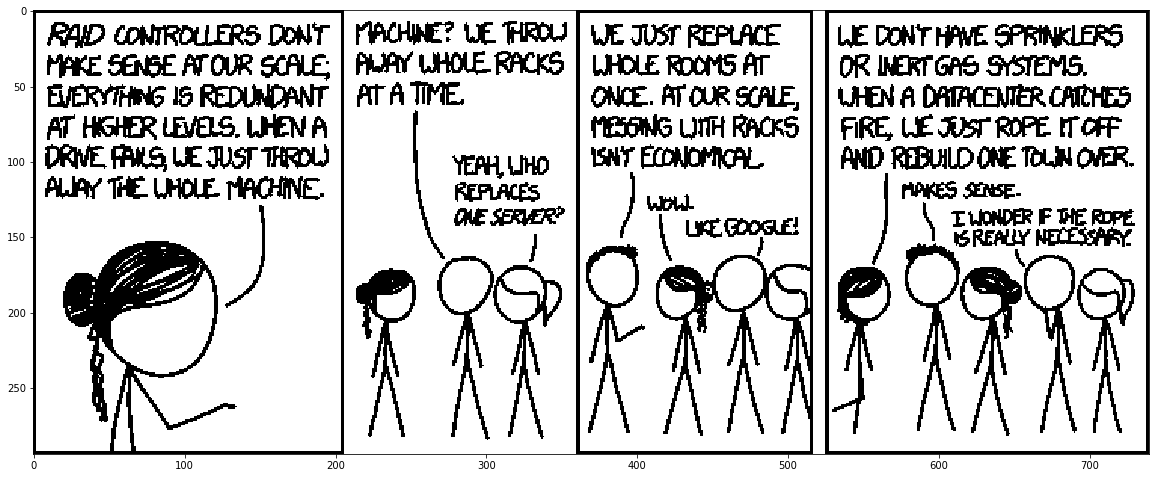

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(bw, cmap='gray', interpolation='nearest')

## Inject Noise

In [0]:
noisy_bw = inject_noise(bw, noise_level=0.2)

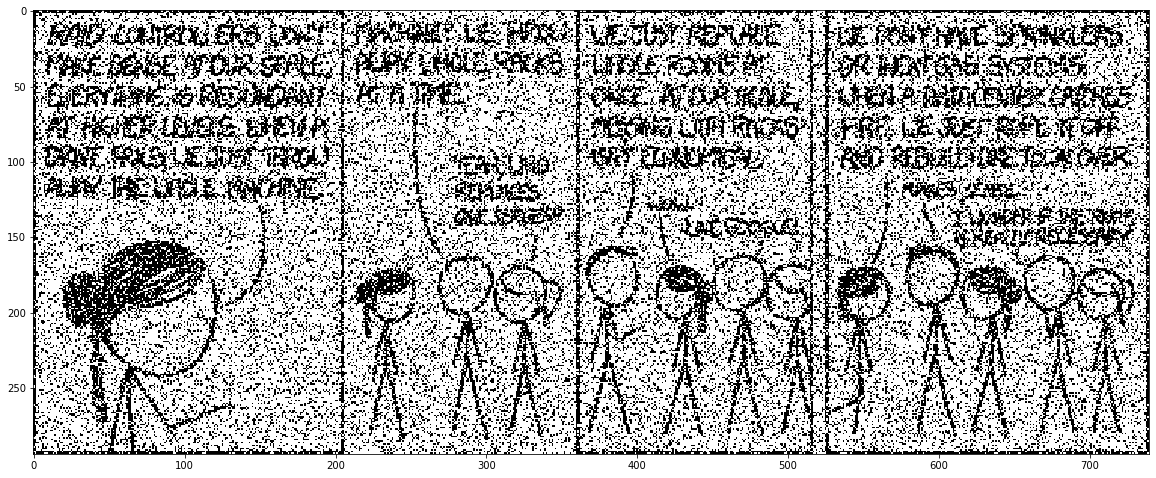

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(noisy_bw, cmap='gray', interpolation='nearest')

## Repetition Code (3x)

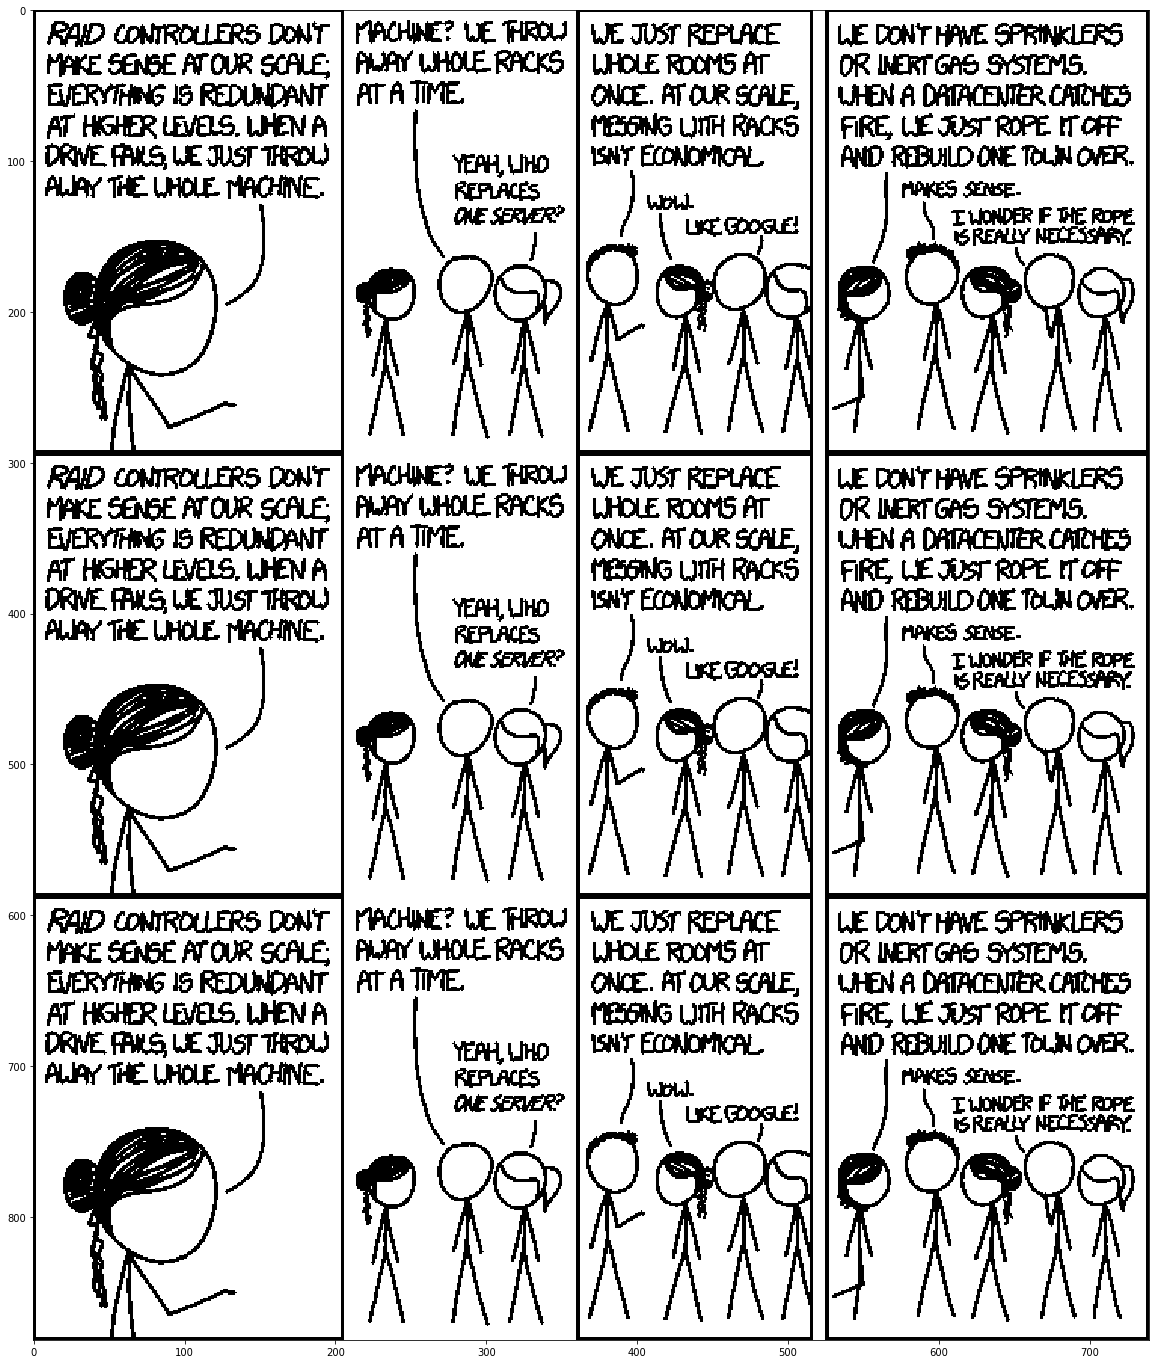

In [10]:
transmit_rep = repetition_encode(bw.reshape(-1), n=3)
rep_bw = repetition_code_img(transmit_rep, bw, n=3)
fig, ax = plt.subplots(figsize=(20, 30))
ax.imshow(rep_bw, cmap='gray', interpolation='nearest')

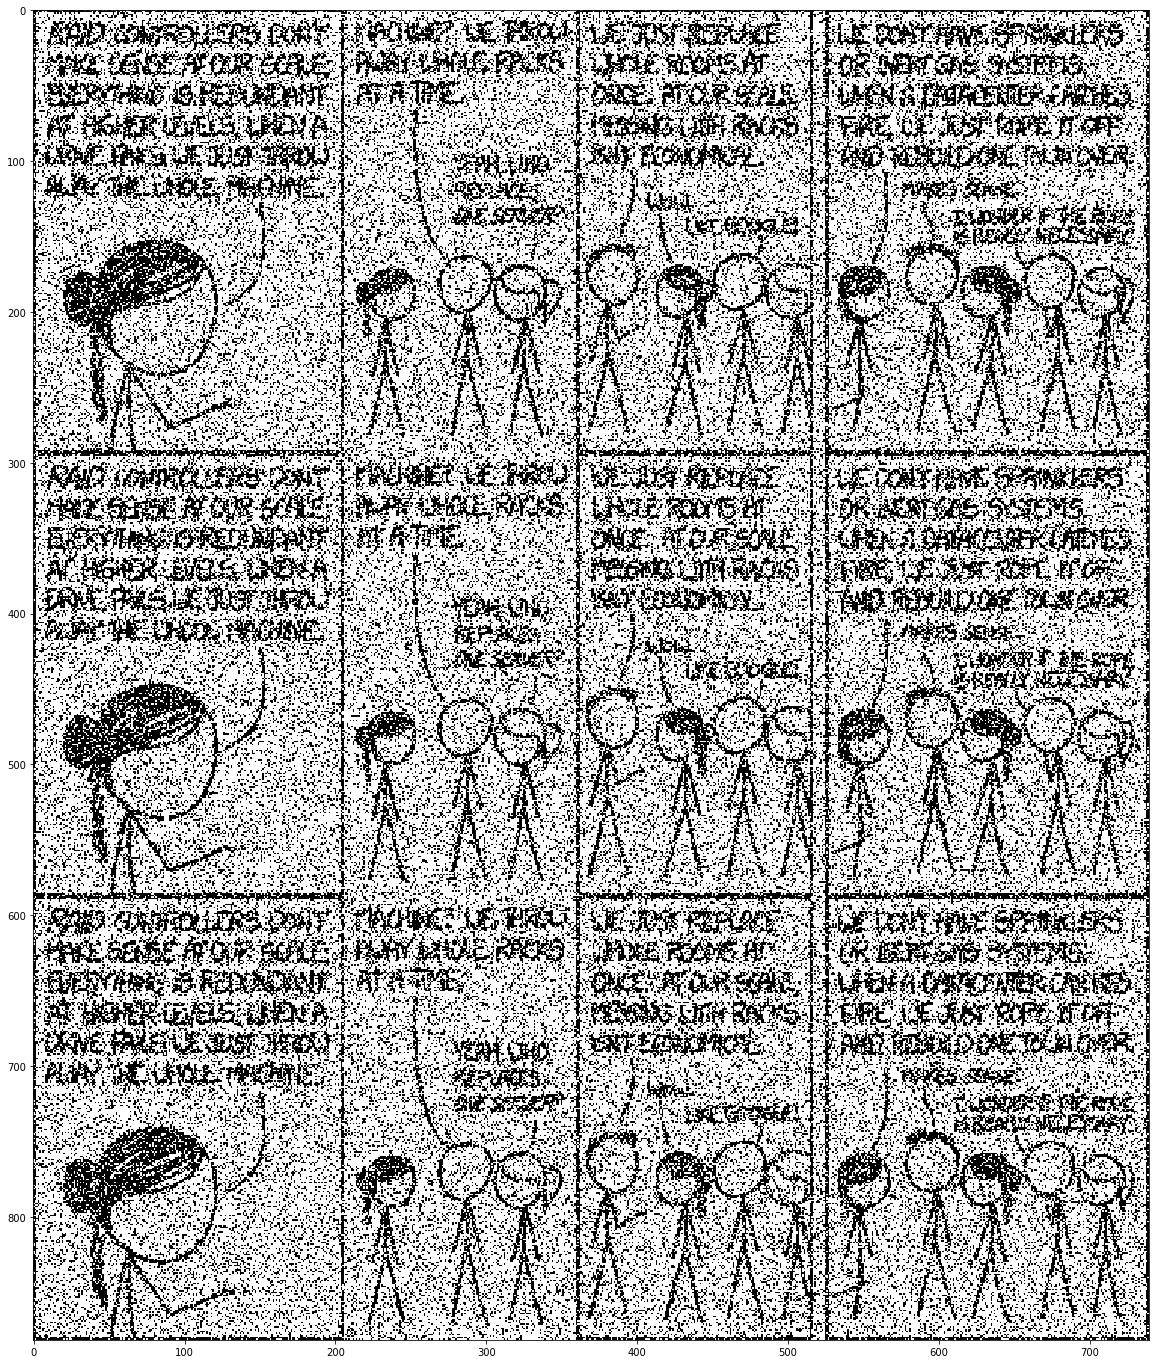

In [11]:
received_rep = inject_noise(transmit_rep, noise_level=0.2)
rep_bw = repetition_code_img(received_rep, bw, n=3)
fig, ax = plt.subplots(figsize=(20, 30))
ax.imshow(rep_bw, cmap='gray', interpolation='nearest')

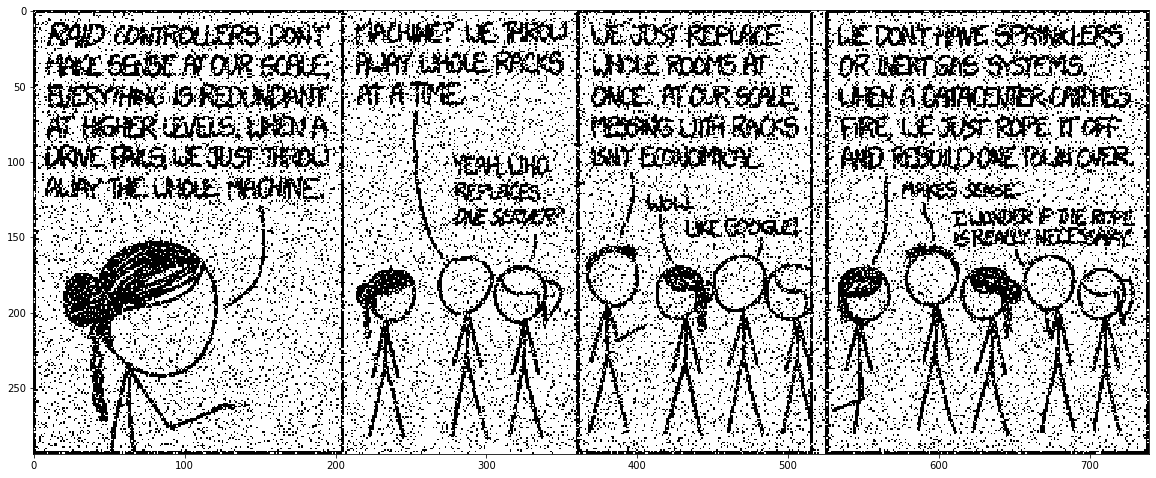

In [12]:
rep_decoded = repetition_decode(received_rep)
rep_dec_bw = rep_decoded.reshape(bw.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(rep_dec_bw, cmap='gray', interpolation='nearest')

## Hamming Code

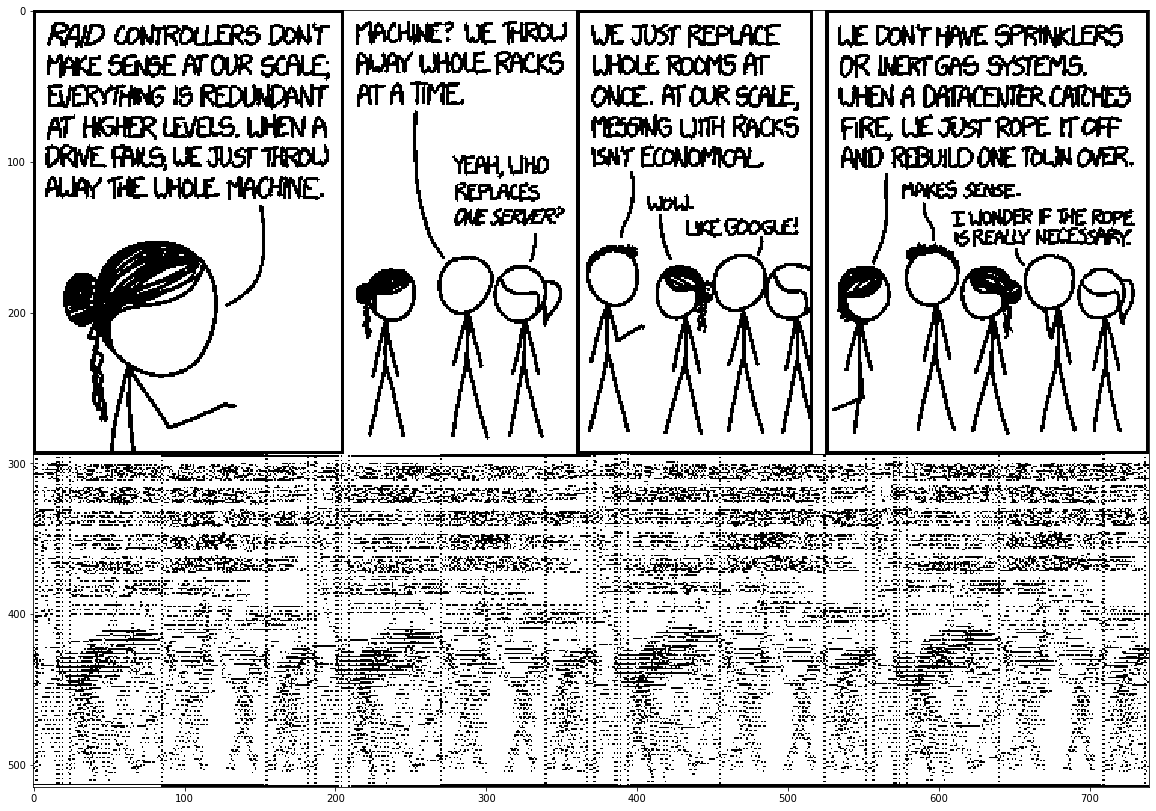

In [13]:
code = hamming_encode(bw)
bw_code = hamming_code_img(code, bw)
fig, ax = plt.subplots(figsize=(20, 17))
ax.imshow(bw_code, cmap='gray', interpolation='nearest')

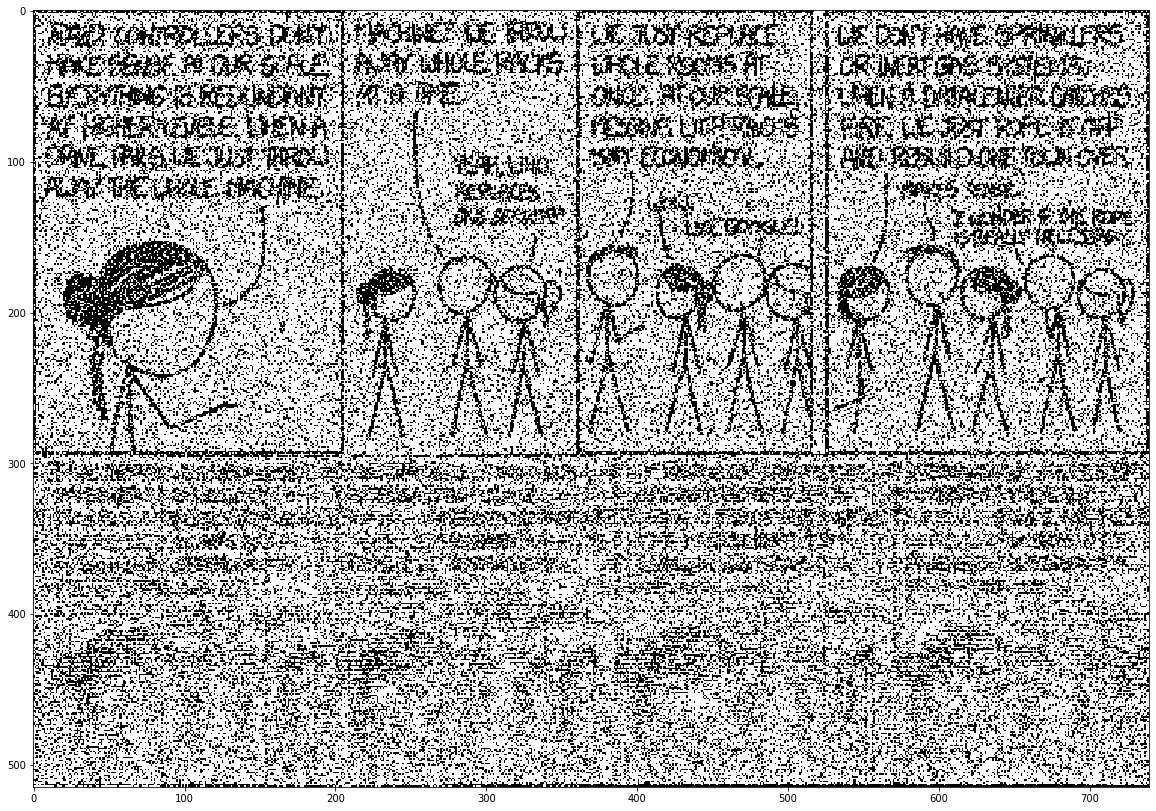

In [14]:
noisy = inject_noise(code, noise_level=0.2)
bw_noisy = hamming_code_img(noisy, bw)
fig, ax = plt.subplots(figsize=(20, 17))
ax.imshow(bw_noisy, cmap='gray', interpolation='nearest')

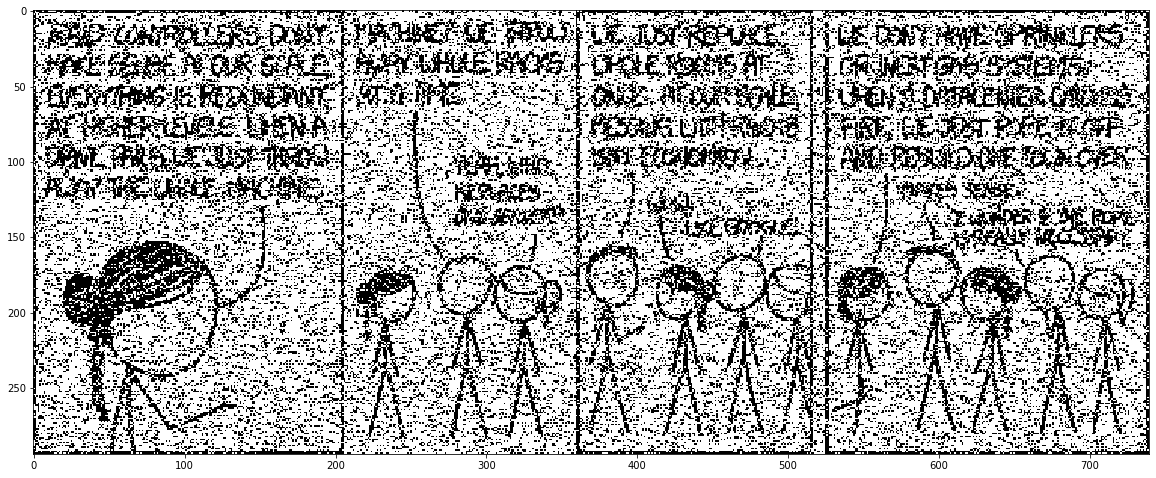

In [15]:
received = hamming_decode(noisy)
bw_received = received[:bw.size].reshape(bw.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(bw_received, cmap='gray', interpolation='nearest')

## Exercises

In [16]:
### Exercise 1.5
print(hamming_decode(np.array([1, 1, 0, 1, 0, 1, 1])))
print(hamming_decode(np.array([0, 1, 1, 0, 1, 1, 0])))
print(hamming_decode(np.array([0, 1, 0, 0, 1, 1, 1])))
print(hamming_decode(np.array([1, 1, 1, 1, 1, 1, 1])))

[1 1 0 0]
[0 1 0 0]
[0 1 0 0]
[1 1 1 1]
